In [1]:
import nasdaqdatalink
import numpy as np
import pandas as pd
import re


Input:
Tickers,Weights

In [2]:
tickers=['SPX','AAPL','MSFT','AMZN']
weights=[-1,1/3,1/3,1/3]

In [3]:
class nasdaq_helper:
    def __init__(self):
        pass
    @staticmethod
    def convert_tickers_to_nasdaq(tickers):
        result=["OPT/"+ticker for ticker in tickers]
        return result
    

In [4]:
opt_tick=nasdaq_helper.convert_tickers_to_nasdaq(tickers)
opt_tick

['OPT/SPX', 'OPT/AAPL', 'OPT/MSFT', 'OPT/AMZN']

In [5]:
data = nasdaqdatalink.get(opt_tick)

In [6]:
row=data.iloc[0].to_dict()
out_terms=np.array([1,30,60,90,120,540])
data['OPT/AAPL - 10dORHV']
data

,OPT/SPX - stockpx,OPT/SPX - iv30,OPT/SPX - iv60,OPT/SPX - iv90,OPT/SPX - m1atmiv,OPT/SPX - m1dtex,OPT/SPX - m2atmiv,OPT/SPX - m2dtex,OPT/SPX - m3atmiv,OPT/SPX - m3dtex,...,OPT/AMZN - 10dclsHV,OPT/AMZN - 20dclsHV,OPT/AMZN - 60dclsHV,OPT/AMZN - 120dclsHV,OPT/AMZN - 252dclsHV,OPT/AMZN - 10dORHV,OPT/AMZN - 20dORHV,OPT/AMZN - 60dORHV,OPT/AMZN - 120dORHV,OPT/AMZN - 252dORHV
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1132.99,16.08,17.73,19.63,15.12,14.0,16.83,49.0,18.80,77.0,...,28.60,29.69,61.69,50.89,52.08,29.64,33.10,44.47,39.60,47.22
2010-01-05,1136.52,15.86,17.18,19.04,15.26,13.0,16.27,48.0,18.10,76.0,...,28.38,28.59,61.68,50.73,52.07,29.69,30.63,44.46,39.54,47.15
2010-01-06,1137.14,15.31,17.01,18.43,13.29,12.0,16.53,47.0,17.43,75.0,...,25.78,28.01,61.88,50.80,51.80,28.53,29.74,44.55,39.50,46.81
2010-01-07,1141.69,15.59,16.79,18.31,14.53,11.0,16.15,46.0,17.28,74.0,...,26.57,28.58,61.79,50.88,51.79,29.08,30.09,44.44,39.58,46.80
2010-01-08,1144.98,14.32,16.11,17.52,12.80,10.0,15.03,45.0,16.83,73.0,...,22.18,29.27,61.92,50.87,51.82,28.02,30.20,44.70,39.61,46.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-15,4147.60,16.19,16.43,16.43,18.09,4.0,16.20,32.0,16.30,67.0,...,59.35,48.37,40.70,43.96,47.65,51.85,46.27,41.87,45.22,47.13
2023-02-16,4090.41,17.37,18.40,17.17,22.32,3.0,17.37,31.0,17.12,66.0,...,44.02,49.15,41.15,43.95,47.73,46.67,46.50,41.89,45.25,47.16
2023-02-17,4079.09,17.31,17.41,17.37,17.58,2.0,17.50,30.0,17.31,65.0,...,23.19,47.59,41.03,43.47,47.72,34.82,45.19,41.53,44.85,47.16


In [9]:

#row=data[0].to_dict()
row=data.iloc[-1].to_dict()
#compute vols
import py_vollib.black_scholes
import py_vollib_vectorized
def process_orats_vols_row(row,out_terms, opt_tick=None):
    if opt_tick is None:
        opt_tick=[""]
    result={}
    
    for ticker in opt_tick:
        terms={'iv30':30,
            'iv60':60,
            'iv90':90}
        terms={ticker+" - "+k:v for k,v in terms.items()}
        for i in range(1,5):
            terms[ticker+" - "+'m'+str(i)+'atmiv']=row[ticker+" - "+"m"+str(i)+"dtex"]

        sorted_arr=sorted(terms.items(), key=lambda x: x[1])
        terms=np.array([x[1] for x in sorted_arr])
        vols=np.array([row[x[0]] for x in sorted_arr])

        weights30=np.sqrt(30)/np.sqrt(np.maximum(terms,30))
        weights_inf=1-weights30
        orats_interp_slopes=weights30*row[ticker+" - "+"slope"]+(1-weights30)*row[ticker+" - "+"slope_inf"]
        orats_interp_derivs=weights30*row[ticker+" - "+"deriv"]+(1-weights30)*row[ticker+" - "+"deriv_inf"]
        texp=terms/365.25

        option_price90=py_vollib_vectorized.models.vectorized_black_scholes_merton('c', 100,95,texp, 0, vols/100,0,return_as='array')
        option_greeks90 = py_vollib_vectorized.get_all_greeks('c', 100,95,texp, 0, vols/100,0,model='black_scholes_merton', return_as='dict')
        option_price110=py_vollib_vectorized.models.vectorized_black_scholes_merton('c', 100,105,texp, 0, vols/100,0,return_as='array')
        option_greeks110 = py_vollib_vectorized.get_all_greeks('c', 100,105,texp, 0, vols/100,0,model='black_scholes_merton', return_as='dict')
        delta90=np.array(option_greeks90['delta'])
        delta110=np.array(option_greeks110['delta'])
        vols90=vols*(1+(orats_interp_slopes/1000+(orats_interp_derivs/1000*(delta90*100-50)/2))*(delta90*100-50))
        vols110=vols*(1+(orats_interp_slopes/1000+(orats_interp_derivs/1000*(delta110*100-50)/2))*(delta110*100-50))
        log_slopes=(vols110-vols90)/(np.log(1.05/.95)*10)*np.sqrt(texp)
        log_slopes
        out_slopes=np.interp(out_terms,terms,log_slopes)
        out_vols=np.interp(out_terms,terms,vols)
        #print("out_terms={}".format(out_terms))
        #result["date"]=row.index[0]
        for i in range(len(out_terms)):
            result[ticker+" - "+'iv'+str(int(out_terms[i]))]=out_vols[i]
            result[ticker+" - "+'slope'+str(int(out_terms[i]))]=out_slopes[i]
        result[ticker+" - "+"stockpx"]=row[ticker+" - "+"stockpx"]
    return result

process_orats_vols_row(row,out_terms,tickers)

{'SPX - iv1': 20.08,
 'SPX - slope1': -1.9775218458011805,
 'SPX - iv30': 20.49,
 'SPX - slope30': -2.033340812711281,
 'SPX - iv60': 18.99,
 'SPX - slope60': -2.471283461066471,
 'SPX - iv90': 18.69,
 'SPX - slope90': -2.690587398068428,
 'SPX - iv120': 18.52,
 'SPX - slope120': -2.8127215111095247,
 'SPX - iv540': 18.52,
 'SPX - slope540': -2.8127215111095247,
 'SPX - stockpx': 3991.05,
 'AAPL - iv1': 29.25,
 'AAPL - slope1': -1.3595471246804962,
 'AAPL - iv30': 29.58,
 'AAPL - slope30': -1.378907614375959,
 'AAPL - iv60': 28.23,
 'AAPL - slope60': -1.5332918112237024,
 'AAPL - iv90': 29.79,
 'AAPL - slope90': -1.6162865420307089,
 'AAPL - iv120': 29.18,
 'AAPL - slope120': -1.6566368182097788,
 'AAPL - iv540': 29.18,
 'AAPL - slope540': -1.6566368182097788,
 'AAPL - stockpx': 148.91,
 'MSFT - iv1': 29.67,
 'MSFT - slope1': -1.053563886424379,
 'MSFT - iv30': 29.78,
 'MSFT - slope30': -1.069162944950804,
 'MSFT - iv60': 28.6,
 'MSFT - slope60': -1.2428051507596058,
 'MSFT - iv90': 29

In [10]:
import re
data.columns=[re.sub("OPT/", "", x) for x in data.columns]


out_rows=[process_orats_vols_row(row,out_terms,tickers) for row in data.to_dict(orient='records')]
#out_rows

data.to_dict(orient='records')
df=pd.DataFrame(out_rows)
df.index=data.index


In [10]:
px_cols=[x+" - stockpx" for x in tickers]
df_prices=df[px_cols].fillna(method='ffill')
#need to clean up data separately instead of fillna() this is temporary
df_prices.columns=[re.sub(" \- stockpx", "", x) for x in df_prices.columns]
df_realized_vols=np.sqrt(np.square(np.log(df_prices/df_prices.shift(1))).rolling(20).mean()*252)

In [217]:
data[df_prices['SPX'].isna()]

,SPX - stockpx,SPX - iv30,SPX - iv60,SPX - iv90,SPX - m1atmiv,SPX - m1dtex,SPX - m2atmiv,SPX - m2dtex,SPX - m3atmiv,SPX - m3dtex,...,AMZN - 10dclsHV,AMZN - 20dclsHV,AMZN - 60dclsHV,AMZN - 120dclsHV,AMZN - 252dclsHV,AMZN - 10dORHV,AMZN - 20dORHV,AMZN - 60dORHV,AMZN - 120dORHV,AMZN - 252dORHV
date,,,,,,,,,,,,,,,,,,,,,


In [16]:
df[["SPX - iv30","SPX - iv60","SPX - iv90","SPX - iv120","SPX - iv540", "SPX - stockpx", "SPX - slope30", "SPX - slope60", "SPX - slope90", "SPX - slope120", "SPX - slope540"]].to_csv("SPX.csv")

In [11]:
df_realized_vols["dispersion"]=df_realized_vols.to_numpy()[:,:]@weights

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display

def graph_vol_period(endDate,period,end_date_loc):
    fig, ax1 = plt.subplots(figsize=(8, 8))

    title="SPX Volatility"
    subtitle="30, 60, 90, 120, 540 day implied volatilities and slopes"
    col_count=0
    for col in df_realized_vols.columns:
        if(col=="dispersion"):
            ax1.plot(df_realized_vols.index,df_realized_vols[col],label = f'{col}')
        else:
            col_count+=1
            ax1.plot(df_realized_vols.index,df_realized_vols[col],label = f'{col}',color='grey',alpha=0.1*col_count)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals = 2))
    plt.ylim([0, .7])
    plt.gca().spines[['left','right', 'top']].set_visible(False)

    plt.grid(axis = 'x',alpha = 0.4)
    plt.legend(loc = 'best',ncol = 1)
    localEndDate=df.index[end_date_loc]
    left=localEndDate-datetime.timedelta(days=period*365)
    right=localEndDate
    #left=datetime.datetime(2019, 1, 1)
    #right=datetime.datetime(2020, 1, 1)

# Format the date into months & days
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y')) 

# Change the tick interval
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 

# Puts x-axis labels on an angle
    plt.gca().xaxis.set_tick_params(rotation = 90)  

# Changes x-axis range
    plt.gca().set_xbound(left, right)

#graph_vol_period(datetime.datetime(2019, 1, 1),2)

w_end_date = widgets.DatePicker(
    description='End Date',
    value=datetime.date(2020, 1, 1),
    disabled=False
)
w_graph_duration = widgets.BoundedFloatText(
    value=1,
    min=0,
    max=10,
    step=0.1,
    description='Graph Duration:',
    disabled=False
)

w_date_slider=widgets.IntSlider(
    value=7,
    min=0,
    max=len(df.index)-1,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def update_graph(end_date,graph_duration):
    left=end_date-datetime.timedelta(days=graph_duration*365)
    right=end_date
    plt.gca().set_xbound(left, right)
    plt.show()

#w_out=widgets.interactive_output(graph_vol_period, {'endDate' w_end_date, 'period': w_graph_duration})
w_out=widgets.interactive_output(graph_vol_period, {'endDate': w_end_date, 'period': w_graph_duration, 'end_date_loc': w_date_slider})

display(widgets.VBox([widgets.HBox([w_end_date,w_graph_duration,w_date_slider]),w_out]))
#widgets.interactive_output(graph_vol_period, {'endDate' w_end_date, 'period': w_graph_duration})
#w_end_date.observe(lambda x: update_graph(w_end_date.value,w_graph_duration.value), names='value')

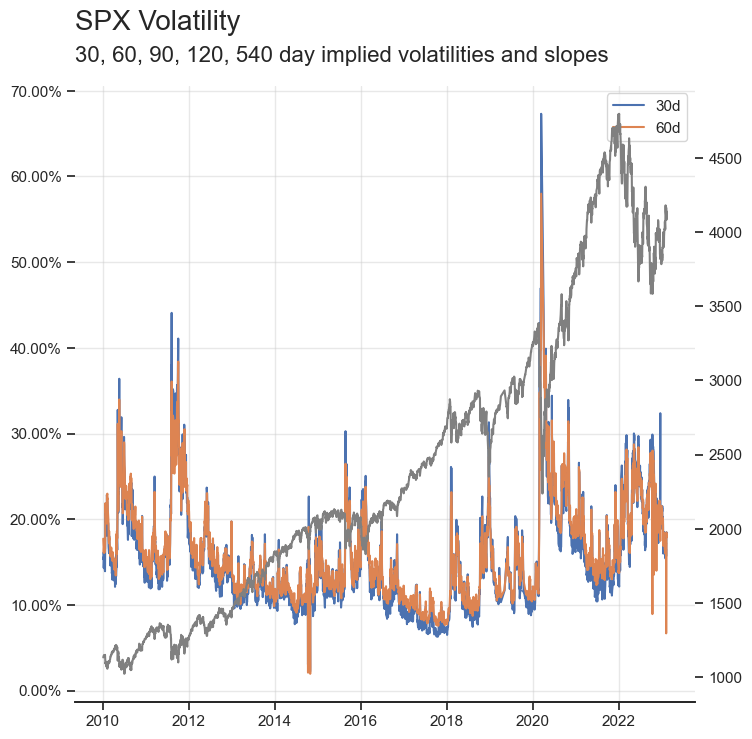

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots(figsize=(8, 8))

title="SPX Volatility"
subtitle="30, 60, 90, 120, 540 day implied volatilities and slopes"
    # add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.95,s = title,fontname = 'Arial',
    fontsize = 20,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.91,s = subtitle,fontname = 'Arial',
    fontsize = 16,ha = 'left',transform = fig.transFigure
)


ax1.plot(df.index,df['iv30']/100, label = '30d')
ax1.plot(df.index,df['iv60']/100, label = '60d')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals = 2))
plt.gca().spines[['left','right', 'top']].set_visible(False)

plt.grid(axis = 'both',alpha = 0.45)
plt.legend(loc = 'best',ncol = 1)
ax2 = ax1.twinx()
ax2.plot(df.index,df['stockpx'], color = 'grey', label='SPX')
plt.gca().spines[['left','right', 'top']].set_visible(False)
#


,align,choice,time,coherence,firing_rate
0,dots,T1,-80,0.0,33.189967
1,dots,T1,-80,3.2,31.691726
2,dots,T1,-80,6.4,34.279840
3,dots,T1,-80,12.8,32.631874
4,dots,T1,-80,25.6,35.060487
...,...,...,...,...,...
843,sacc,T2,300,3.2,33.281734
844,sacc,T2,300,6.4,27.583979
845,sacc,T2,300,12.8,28.511530
846,sacc,T2,300,25.6,27.009804


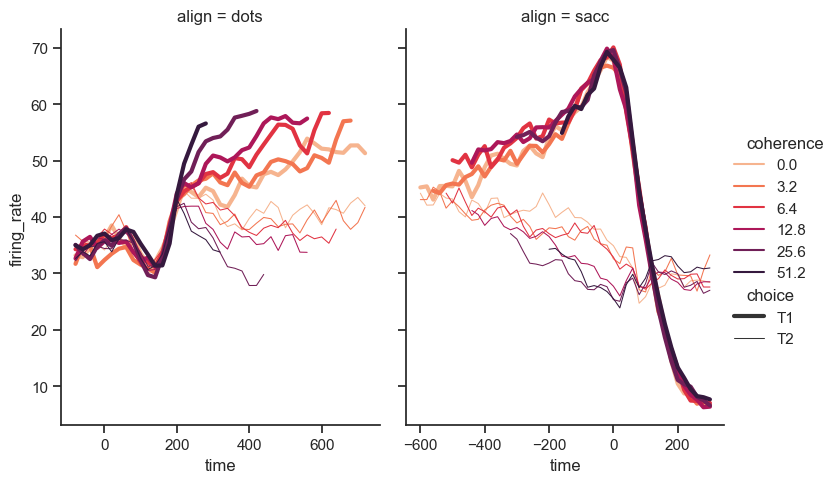

In [13]:
import seaborn as sns
sns.set_theme(style="ticks")

dots = sns.load_dataset("dots")

# Define the palette as a list to specify exact values
palette = sns.color_palette("rocket_r")

# Plot the lines on two facets
sns.relplot(
    data=dots,
    x="time", y="firing_rate",
    hue="coherence", size="choice", col="align",
    kind="line", size_order=["T1", "T2"], palette=palette,
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)
dots


In [244]:
#df=df_realized_vols.copy()
#df[["AAPL","MSFT","AMZN"]]
df

,SPX - iv1,SPX - slope1,SPX - iv30,SPX - slope30,SPX - iv60,SPX - slope60,SPX - iv90,SPX - slope90,SPX - iv120,SPX - slope120,...,AMZN - slope30,AMZN - iv60,AMZN - slope60,AMZN - iv90,AMZN - slope90,AMZN - iv120,AMZN - slope120,AMZN - iv540,AMZN - slope540,AMZN - stockpx
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,15.12,-1.582319,16.08,-1.980585,17.73,-2.304929,19.63,-2.445982,19.47,-2.477430,...,-0.660839,46.78,-0.841210,44.72,-0.920904,43.795934,-0.964442,43.37,-1.048064,133.90
2010-01-05,15.26,-1.504901,15.86,-1.910908,17.18,-2.241417,19.04,-2.392252,18.87,-2.424075,...,-0.650153,46.94,-0.825742,44.24,-0.902228,43.256923,-0.943943,43.43,-1.025702,134.69
2010-01-06,13.29,-1.266247,15.31,-1.818289,17.01,-2.182068,18.43,-2.334793,18.53,-2.371387,...,-0.696832,45.37,-0.862460,43.18,-0.934387,42.307253,-0.973531,41.86,-1.050442,132.25
2010-01-07,14.53,-1.259146,15.59,-1.756431,16.79,-2.112218,18.31,-2.274502,18.80,-2.316410,...,-0.728199,45.68,-0.890827,43.48,-0.961053,42.698791,-0.998892,42.41,-1.073605,130.00
2010-01-08,12.80,-1.002033,14.32,-1.565495,16.11,-1.981440,17.52,-2.159981,17.48,-2.195867,...,-0.732757,44.08,-0.907180,42.39,-0.983350,41.752198,-1.023693,41.23,-1.102628,133.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10,22.54,-1.527832,18.17,-1.780419,18.46,-2.296057,18.02,-2.531163,18.02,-2.589288,...,-0.669076,38.68,-0.855131,40.09,-0.950508,40.940000,-0.975091,40.94,-0.975091,97.61
2023-02-13,25.90,-1.489199,18.34,-1.805496,17.89,-2.308445,17.60,-2.550210,17.56,-2.591575,...,-0.794202,38.39,-0.947194,39.96,-1.029045,40.470000,-1.044028,40.47,-1.044028,99.54
2023-02-14,18.84,-1.126488,16.54,-1.789560,16.70,-2.311822,16.61,-2.557923,16.58,-2.593586,...,-0.732390,36.44,-0.893863,38.45,-0.979761,38.900000,-0.993152,38.90,-0.993152,99.70


/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_27786/4212456273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bla["date"]=[x.year for x in bla.index]


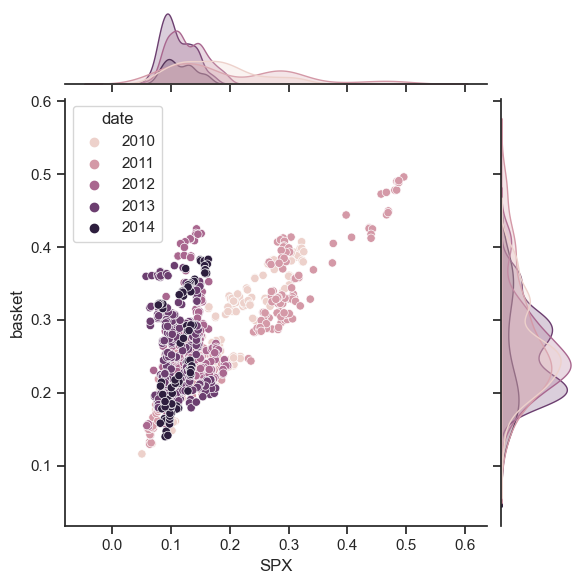

In [23]:
import seaborn as sns
sns.set_theme(style="ticks")
df_basket=df_realized_vols.copy()
df_basket["date"]=df_realized_vols.index
df_basket["basket"]=df_realized_vols[["AAPL","MSFT","AMZN"]].mean(axis=1)
bla=df_basket[["SPX","basket"]]
bla["date"]=[x.year for x in bla.index]
#g=sns.jointplot(df.iloc[1:000,:],x="SPX", y="basket", kind="reg")
sns.jointplot(bla.iloc[1:1100,:],x="SPX", y="basket",hue="date")

In [3]:
#bla=df[["SPX","basket"]]

df_spx=df_realized_vols[["SPX"]].copy()
df_spx["vol"]=df_spx["SPX"]
df_spx["price"]=df_prices["SPX"]
df_spx
df_spx["roll_max"]=df_spx["price"].rolling(250).max()
df_spx["roll_min"]=df_spx["price"].rolling(250).min()
df_spx["upside"]=df_spx["roll_max"]/df_spx["price"]-1
df_spx["downside"]=df_spx["price"]/df_spx["roll_min"]-1
df_spx["ivol"]=df['SPX - iv60'].fillna(method='ffill')/100
df_spx["slope"]=df['SPX - slope60'].fillna(method='ffill')/100
df_spx["return"]=np.log(df_spx["price"]).diff()
df_spx["vol_return"]=df_spx["ivol"].diff()/100
#df_spx["vol_slope"]=df_spx["slope"].diff()/100
df_spx["spot_vol_regression"]=df_spx.rolling(20).cov().unstack()['return']['vol_return']/df_spx.rolling(20).var()['return']*np.sqrt(252/60)*100
fig, ax= plt.subplots(4,1,figsize=(20, 10))
ax[0].plot(df_spx.index,np.log(df_spx["price"]))
#ax[0].yscale('log')
ax[1].plot(df_spx.index,df_spx["vol"])
ax[1].plot(df_spx.index,df_spx["ivol"])
ax[2].plot(df_spx.index,df_spx["upside"])
ax[2].plot(df_spx.index,df_spx["downside"])
ax[3].plot(df_spx.index,df_spx["spot_vol_regression"])
ax[3].plot(df_spx.index,df_spx["slope"]*100)
ax[1].legend(["vol","ivol"])
ax[2].legend(["upside","downside"])
ax[3].legend(["regression slope","implied slope"])
ax[1].set_ylim(0.1,0.4)
ax[3].set_ylim(-5,2)

NameError: name 'df_realized_vols' is not defined

In [2]:
const_slope=0
df_spx2=df_spx.copy()
#df_spx2=df_spx2.resample('1w').last()
df_spx2["px_prev"]=df_spx2["price"].shift(1)
df_spx2["vol_prev"]=df_spx2["vol"].shift(1)
df_spx2["ivol_prev"]=df_spx2["ivol"].shift(1)
df_spx2["slope_prev"]=df_spx2["slope"].shift(1)
df_spx2["adjust_vol"]=df_spx2["ivol_prev"]+df_spx2["slope_prev"]*np.log(df_spx2["price"]/df_spx2["px_prev"])/np.sqrt(60/252)*10
df_spx2["curve_move"]=df_spx2["ivol"]-df_spx2["adjust_vol"]
df_spx2["adjust_vol_const"]=df_spx2["ivol_prev"]+const_slope*np.log(df_spx2["price"]/df_spx2["px_prev"])/np.sqrt(60/252)*10
df_spx2["curve_move_const"]=df_spx2["ivol"]-df_spx2["adjust_vol_const"]
fig, ax= plt.subplots(3,1,figsize=(20, 10))
ax[0].plot(df_spx.index,np.log(df_spx["price"]))
#ax[0].yscale('log')
#ax[1].plot(df_spx.index,df_spx["curve_move"])
ax[1].plot(df_spx2.index,df_spx2["curve_move"].cumsum(),label="slope")
ax[1].plot(df_spx2.index,df_spx2["curve_move_const"].cumsum(), label="const")
#ax[1].plot(df_spx.index,df_spx["ivol"])
#ax[2].scatter(df_spx["curve_move"],df_spx["price"]/df_spx["px_prev"]-1)
df_spx2["long_return"]=df_spx2["price"]/df_spx2["px_prev"]-1
df_spx2["long_return"]
ax[2].scatter(df_spx["curve_move"],df_spx["long_return"])

NameError: name 'df_spx' is not defined

In [77]:
df_spx2["slope"]

date
2010-01-10   -0.019814
2010-01-17   -0.022464
2010-01-24   -0.030230
2010-01-31   -0.024454
2010-02-07   -0.025222
                ...   
2023-01-22   -0.021199
2023-01-29   -0.021117
2023-02-05   -0.022014
2023-02-12   -0.022961
2023-02-19   -0.024743
Freq: W-SUN, Name: slope, Length: 685, dtype: float64